In [ ]:
!/usr/bin/python3 -m pip install --upgrade pip
!apt-get update
!apt-get install git -y
!git clone https://github.com/Xtraordinaire9911/neural_network_building.git
!pip3 install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html
!pip install tqdm
!pip install matplotlib
!pip install tensorboard
!pip install tensorboardX

In [ ]:
!nvidia-smi

Tue Jun 15 00:31:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:68:00.0 Off |                  N/A |
| 30%   44C    P8    27W / 350W |      1MiB / 24268MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# %%timeit
import os
import json
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import torch.optim as optim
from tqdm import tqdm
import numpy as np

from model_googlenet import GoogLeNet

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
def train():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))

    data_transform = {
        "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
        "val": transforms.Compose([transforms.Resize((224, 224)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}
    
    print('current root:', os.getcwd())
#     data_root = os.path.abspath(os.path.join(os.getcwd(), ".."))  # get data root path
    data_root = os.getcwd()
    print('data_root:', data_root)
    image_path = os.path.join(data_root, "dataset", "flower_data")  # flower data set path
    assert os.path.exists(image_path), "{} path does not exist.".format(image_path)
    train_dataset = datasets.ImageFolder(root=os.path.join(image_path, "train"),
                                         transform=data_transform["train"])
    train_num = len(train_dataset)

    # {'daisy':0, 'dandelion':1, 'roses':2, 'sunflower':3, 'tulips':4}
    flower_list = train_dataset.class_to_idx
    cla_dict = dict((val, key) for key, val in flower_list.items())
    # write dict into json file
    json_str = json.dumps(cla_dict, indent=4)
    with open('class_indices.json', 'w') as json_file:
        json_file.write(json_str)

    batch_size = 32
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    print('Using {} dataloader workers every process'.format(nw))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size, shuffle=True,
                                               num_workers=nw)

    validate_dataset = datasets.ImageFolder(root=os.path.join(image_path, "val"),
                                            transform=data_transform["val"])
    val_num = len(validate_dataset)
    validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                                  batch_size=batch_size, shuffle=True,
                                                  num_workers=nw)

    print("using {} images for training, {} images for validation.".format(train_num,
                                                                           val_num))

    # test_data_iter = iter(validate_loader)
    # test_image, test_label = test_data_iter.next()

    # net = torchvision.models.googlenet(num_classes=5)
    # model_dict = net.state_dict()
    # pretrain_model = torch.load("googlenet.pth")
    # del_list = ["aux1.fc2.weight", "aux1.fc2.bias",
    #             "aux2.fc2.weight", "aux2.fc2.bias",
    #             "fc.weight", "fc.bias"]
    # pretrain_dict = {k: v for k, v in pretrain_model.items() if k not in del_list}
    # model_dict.update(pretrain_dict)
    # net.load_state_dict(model_dict)
    net = GoogLeNet(num_classes=5, if_aux_logits=True, if_init_weights=True)
    net.to(device)
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.0003)

    epochs = 150
    best_acc = 0.0
    l_loss = []
    l_acc = []
    save_path = './GoogLeNet.pth'
    train_steps = len(train_loader)
    for epoch in range(epochs):
        # train
        net.train()
        running_loss = 0.0
        train_bar = tqdm(train_loader)
        for step, data in enumerate(train_bar):
            images, labels = data
            optimizer.zero_grad()
            logits, aux_logits2, aux_logits1 = net(images.to(device))
            loss0 = loss_function(logits, labels.to(device))
            loss1 = loss_function(aux_logits1, labels.to(device))
            loss2 = loss_function(aux_logits2, labels.to(device))
            loss = loss0 + loss1 * 0.3 + loss2 * 0.3
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            l_loss.append(running_loss)

            train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                     epochs,
                                                                     loss)

        # validate
        net.eval()
        acc = 0.0  # accumulate accurate number / epoch
        with torch.no_grad():
            val_bar = tqdm(validate_loader)
            for val_data in val_bar:
                val_images, val_labels = val_data
                outputs = net(val_images.to(device))  # eval model only have last output layer
#                 if epoch == 0:
#                     print(type(outputs[0]), outputs[0].size())
#                 predict_y = torch.max(outputs[0], dim=1)
#                 if epoch == 0:
#                     print(type(predict_y[1]), len(predict_y[1]))
                acc += torch.eq(predict_y[1], val_labels.to(device)).sum().item()

        val_accurate = acc / val_num
        l_acc.append(val_accurate)
        print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
              (epoch + 1, running_loss / train_steps, val_accurate))

        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)
            
        if epoch > 10 and np.max(l_acc[-10:]) - np.min(l_acc[-10:]) < 0.02 and val_accurate > 0.75:
            break

    print('Finished Training')
    return l_loss, l_acc

In [ ]:
%%time

from tensorboardX import SummaryWriter
writer1 = SummaryWriter('runs02/accuracy')
# start tensorboard
%load_ext tensorboard
%tensorboard --logdir=runs02/accuracy
l_train_loss, l_accuracy = train()

In [ ]:
!nvidia-smi --query-gpu=memory.free --format=csv

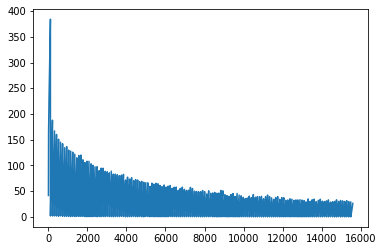

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(l_train_loss)

(0.0, 1.0)

Text(3.5, 0.7802197802197801, '0.83')

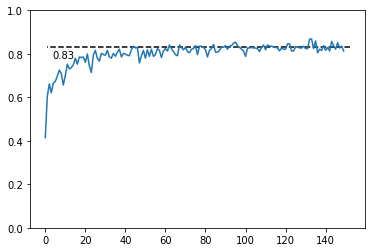

In [ ]:
fig = plt.figure()
# plt.xlim(-2, len(l_accuracy)+1)
plt.ylim(0, 1)
plt.hlines(np.mean(l_accuracy[-10:]), len(l_accuracy)+2, l_accuracy[-1], linestyle="dashed", color="black")
plt.text(3.5, np.mean(l_accuracy[-10:])-0.05, '{}'.format(np.round(np.mean(l_accuracy[-10:]), 2), ha='center', va= 'bottom'))
plt.plot(l_accuracy)

In [ ]:
# len(l_train_loss)
# print(list(map(lambda x: round(x, 2), l_train_loss)))

In [ ]:
# len(l_accuracy)
# print(list(map(lambda x: round(x, 3), l_accuracy)))